In [3]:
import gc
import os
import json
import math
import torch

import numpy as np
import mlx.nn as nn
import mlx.core as mx
import mlx.utils as mxutils

import numpy as np
from PIL import Image
from tqdm import tqdm

from safetensors.torch import load_file
from modules.tokenizers import CLIPTokenizer
from modules.layers import CLIP, Diffusion, Encoder, Decoder
from modules.scheduler import DDPMSampler, EulerAncestralSampler
from modules.mappings import simplified_clip_lora_mapping, simplified_unet_lora_mapping
from modules.loaders import load_clip_weights, load_clip_lora, load_unet_weights, load_unet_lora, load_decoder_weights,load_encoder_weights

_uses deliberatev2 checkpoint from https://huggingface.co/stablediffusionapi/deliberate-v2 and taesd from https://github.com/madebyollin/taesd_

In [5]:
original_state_dict = torch.load(os.path.expanduser("~/deliberate_v2.ckpt"),weights_only=True)['state_dict']
decoder_state_dict =  torch.load(os.path.expanduser("~/taesd_decoder.pth"),weights_only=True)
encoder_state_dict =  torch.load(os.path.expanduser("~/taesd_encoder.pth"),weights_only=True)
lora_state_dict = load_file("models/3DMM_V11.safetensors")

In [6]:
encoder = Encoder()
decoder = Decoder()
unet = Diffusion()
clip = CLIP()

In [7]:
def get_time_embedding(timestep):
    freqs = mx.power(10000, -mx.arange(start=0, stop=160, dtype=mx.float32) / 160)  # Shape: (160,)
    x = mx.array([timestep], dtype=mx.float32).reshape(-1, 1) * freqs.reshape(1, -1)  # Shape: (1, 160)
    return mx.concatenate([mx.cos(x), mx.sin(x)], axis=-1)  # Shape: (1, 160 * 2)

def createImageGrid(images, scale=0.5, rows=1):
    w,h = images[0].size
    w = int(w*scale)
    h = int(h*scale)
    height = rows*h
    cols = math.ceil(len(images) / rows)
    width = cols*w
    canvas = Image.new('RGB', (width,height), 'white')
    for i,img in enumerate(images):
        img = img.resize((w,h), Image.LANCZOS)
        canvas.paste(img, (w*(i % cols), h*(i // cols))) 
    return canvas

In [8]:
vocab = json.load(open("imports/vocab.json", 'r', encoding='utf-8'))
merges = open("imports/merges.txt", 'r', encoding='utf-8').read().split('\n')

In [9]:
tokenizer = CLIPTokenizer(vocab=vocab,merges=merges)
clip = load_clip_weights(clip,original_state_dict)
unet = load_unet_weights(unet,original_state_dict)
decoder = load_decoder_weights(decoder,decoder_state_dict)
encoder = load_encoder_weights(encoder,encoder_state_dict)

**_load a lora if you'd like from the models folder, Currently using 3DMM https://civitai.com/posts/302945_**

In [10]:
clip = load_clip_lora(clip,lora_state_dict,simplified_clip_lora_mapping)
unet = load_unet_lora(unet,lora_state_dict,simplified_unet_lora_mapping)

  _LORA Repository: https://huggingface.co/Bruhn/7alawiyat_LoRa_collection/tree/5a4c27c00fabf9b08d725248df517cb06322122a_

In [11]:
del original_state_dict
del decoder_state_dict
del encoder_state_dict
del lora_state_dict

In [12]:
gc.collect()

922

In [13]:
original = Image.open("images/test4.jpg")

In [23]:
# prompt = "cartoon illustration, vector art, vexel portrait, thick outline, masterpiece, best quality, highly detailed, trending on artstation, <lora:westernIllustration_westernIllustration:1>"
# uncond_prompt = "blurry eyes, robot eyes, cropped, out of frame, deformed, ugly, malformed, cloned, extra arms, blurry, fuzzy, bad-prompt, caucasian"
prompt = "3dmm style, masterpiece, best quality, cute, trending on artstation, 3d character, pixar rendering"
uncond_prompt = "blurry eyes, robot eyes, cropped, out of frame, cartoon, flat, deformed, ugly, malformed, cloned, extra arms, blurry, fuzzy, bad-prompt, nsfw"
do_cfg = True
cfg_scale = 10  # min: 1, max: 14
strength=0.4
n_inference_steps=50

In [24]:
prompt_encoded = tokenizer.encode(prompt)
unprompt_encoded = tokenizer.encode(uncond_prompt)
context = mx.concatenate([clip(prompt_encoded['input_ids']), clip(unprompt_encoded['input_ids'])])

sampler = DDPMSampler()
sampler.set_inference_timesteps(n_inference_steps)

In [25]:
LATENTS_WIDTH = 768//8
LATENTS_HEIGHT = 768//8
latents_shape = (1, LATENTS_HEIGHT, LATENTS_WIDTH, 4) #NHWC for MLX not torch

In [26]:
input_image = original.convert("RGB").resize((LATENTS_WIDTH*8, LATENTS_HEIGHT*8))
input_image_tensor = np.array(input_image)/255.
input_image_tensor = mx.array(np.expand_dims(input_image_tensor,axis=0))
encoder_noise = mx.zeros(latents_shape)

encoded = encoder(input_image_tensor)
sampler.set_strength(strength=strength)

latents = mx.array(np.array(encoded))
initial_latents = mx.array(np.array(latents))

In [27]:
timesteps = tqdm(sampler.timesteps)
for i, timestep in enumerate(timesteps):
        time_embedding = get_time_embedding(timestep)
        model_input = mx.repeat(latents,2,axis=0)
        mx.eval(model_input)
        model_output = unet(model_input, context, time_embedding)
        mx.eval(model_output)
        output_cond, output_uncond = model_output.split(2,axis=0)
        model_output = cfg_scale * (output_cond - output_uncond) + output_uncond        
        latents = sampler.step(timestep=timestep, latents=latents, model_output=model_output)

100%|██████████| 20/20 [01:25<00:00,  4.26s/it]


In [28]:
decoded = decoder(latents)
mx.eval(decoded)

In [29]:
nn.losses.l1_loss(initial_latents,latents) #check how different from the original image the new one is

array(0.356266, dtype=float32)

In [30]:
denoised = Image.fromarray(np.array(decoded * 255).squeeze().astype("uint8"))

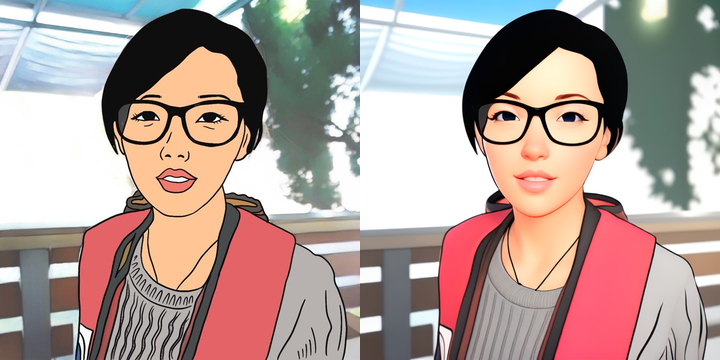

In [ ]:
createImageGrid([original,denoised]) #my original artwork vs 3D look translated from Stable Diffusion